In [1]:
# 导入必需库

import numpy as np
import matplotlib.pyplot as plt # 绘图工具库
import h5py                     # 加载 HDF 工具库
import skimage.transform as tf  # 缩放图片

# jupter notebook 命令， 使matplotlib绘制的图显示在页面里而不是弹出一个窗口
%matplotlib inline

In [14]:
# 加载训练数据和测试数据的函数

def load_dataset():
    # 加载训练数据文件
    train_dataset = h5py.File('./datasets/train_catvnoncat.h5', 'r')
    # 提取训练图片的特征数据
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    # 提取训练图片的标签数据
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])

    # 加载测试数据文件
    test_dataset = h5py.File('./datasets/test_catvnoncat.h5', 'r')
    # 提取测试图片的特征数据
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    # 提取测试图片的标签数据
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])

    # 加载标签列表数据（1代表猫，2代表非猫）
    classes = np.array(test_dataset['list_classes'][:])

    # (209,) => (1, 209)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    # (50, ) => (1, 50)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [36]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

print(f'train_set_x_orig.shape={train_set_x_orig.shape}: 样本数、图片宽、图片长、3个RGB通道')
print(f'train_set_y.shape={train_set_y.shape}')
print(f'test_set_x_orig.shape={test_set_x_orig.shape}: 样本数、图片宽、图片长、3个RGB通道')
print(f'test_set_y.shape={test_set_y.shape}')
print(f'classes.shape={classes.shape}')


train_set_x_orig.shape=(209, 64, 64, 3): 样本数、图片宽、图片长、3个RGB通道
train_set_y.shape=(1, 209)
test_set_x_orig.shape=(50, 64, 64, 3): 样本数、图片宽、图片长、3个RGB通道
test_set_y.shape=(1, 50)
classes.shape=(2,)


备注：train_set_y 为 1 * 209 的矩阵

选取时，需要使用 `train_set_y[0][index]` 获取

或者 `np.squeeze(train_set_y[:, index])`

`np.squeeze` 参考 [CSDN](https://blog.csdn.net/zenghaitao0128/article/details/78512715)

标签为 1, 这是一个 cat 图片


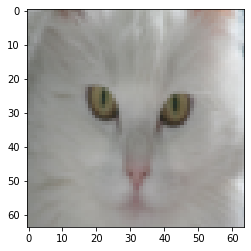

In [34]:
# 选取训练集图片展示

index = 50
plt.imshow(train_set_x_orig[index])

its_y = train_set_y[0][index]
# or its_y = np.squeeze(train_set_y)[index]
# 输出图片信息
print(f'标签为 {str(its_y)}, 这是一个 {classes[its_y].decode("utf-8")} 图片')


In [38]:
# 训练图片数
m_train = train_set_x_orig.shape[0]
# 测试图片数
m_test = test_set_x_orig.shape[0]
# 图片宽高，本次训练和测试的图片均为 64 * 64
num_px = train_set_x_orig.shape[1]

print("训练样本数: m_train = " + str(m_train))
print("测试样本数: m_test = " + str(m_test))
print("每张图片的宽/高: num_px = " + str(num_px))


训练样本数: m_train = 209
测试样本数: m_test = 50
每张图片的宽/高: num_px = 64


In [42]:
# 扁平化和转置，处理后各维度含义 (图片数据、样本数)
# 图片数据即 64 * 64 * 3 = 12288

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))


train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [49]:
# 标准化处理，除以255，使所有值都在 [0, 1] 之间
# 除以 255.0 是为了保持小数位

train_set_x = train_set_x_flatten/255.0
test_set_x = test_set_x_flatten/255.0

至此，数据加载和数据处理部分已经完成，下面进入模型训练部分

![](./images//model_struct.png)

为了构建以上模型，需要编写一些工具函数

1. sigmoid: 把预测结果转换为0和1之间的值

![](./images/sigmoid.png)

In [51]:
# sigmoid 工具函数
# 支持计算一个数或者一个numpy数组

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

初始化权重数组 w 和 偏置 b

In [55]:
# 这里简单将权重数据和偏置都设置成 0

def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

- 前向传播

![](./images/forward_propagation_1.png)

![](./images/forward_propagation_2.png)

- 反向传播

![](./images/backward_propagation.png)


In [56]:
# 传播函数
# 传入 权重数据、偏置、特征、标签

def propagate(w, b, X, Y):
    m = X.shape[1]

    # 前向传播
    # 这里 X 的维度是 (12288, 209)，w 的维度是 (12288, 1)
    # 要使其进行相乘，需要进行矩阵转置
    A = sigmoid(np.dot(w.T, X) + b)
    J = -(1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # 反向传播
    # 这里 dz 维度是 (1, 209)，X 的维度是 (12288, 209)
    # 要使其进行相乘，需要进行矩阵转置
    dz = A - Y
    dw = (1 / m) * np.dot(X, dz.T)
    db = (1 / m) * np.sum(dz)
    
    # 保存 dw, db
    grads = {
        "dw": dw,
        "db": db
    }

    return grads, J

梯度下降

![](./images/gradient_descent_1.png)

In [67]:
# 梯度下降函数
# num_interation 梯度下降次数

def optimize(w, b, X, Y, num_interation, learning_rate, print_cost = False):

    costs = []

    for i in range(num_interation):
        grads, cost = propagate(w, b, X, Y)

        # 从字典中取出梯度
        dw = grads["dw"]
        db = grads["db"]

        # 进行梯度下降
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # 每循环 100 次记录成本
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("优化%i次后成本是: %f" % (i, cost))
    
    # 返回最终优化后的权重数据和偏置
    params = {
        "w": w,
        "b": b
    }

    return params, costs


In [58]:
# 预测函数
# 传入训练好的权重数组和偏置，对测试数据进行预测
# X 的维度是 (12288, 图片张数)

def predict(w, b, X):
    m = X.shape[1]

    # 预测结果，先置为 0
    Y_prediction = np.zeros((1, m))

    # 假设预测图片为50张
    # X 维度为 (12288, 50)，w 维度为 (12288, 1)
    # 需要对 w 进行矩阵转置
    A = sigmoid(np.dot(w.T, X) + b)

    # A 维度为 (1, 50)
    # 对于预测结果 >= 0.5 的，认为是猫，置为 1
    # 对于预测结果 < 0.5 的，认为不是猫，默认为 0
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1

    return Y_prediction

补充：A[0, i] 等于 A[0][i]

In [59]:
# 最终的神经网络模型

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    # 初始化权重数据和偏置
    # 传入特征数
    w, b = initialize_with_zeros(X_train.shape[0])

    # 训练，优化
    parameters, costs = optimize(
        w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # 从字典中分别取出训练好的w和b
    w = parameters["w"]
    b = parameters["b"]

    # 使用训练好的 w, b 来预测训练数据和测试数据
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # 打印准确率
    print(f'对训练图片的预测准确率为: {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100}%')
    print(f'对测试图片的预测准确率为: {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100}%')

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d


In [88]:
# 调用上面的模型函数对我们最开始加载的数据进行训练
d = model(train_set_x, train_set_y, test_set_x, test_set_y,
          num_iterations=2000, learning_rate=0.005, print_cost=True)


优化0次后成本是: 0.693147
优化100次后成本是: 0.584508
优化200次后成本是: 0.466949
优化300次后成本是: 0.376007
优化400次后成本是: 0.331463
优化500次后成本是: 0.303273
优化600次后成本是: 0.279880
优化700次后成本是: 0.260042
优化800次后成本是: 0.242941
优化900次后成本是: 0.228004
优化1000次后成本是: 0.214820
优化1100次后成本是: 0.203078
优化1200次后成本是: 0.192544
优化1300次后成本是: 0.183033
优化1400次后成本是: 0.174399
优化1500次后成本是: 0.166521
优化1600次后成本是: 0.159305
优化1700次后成本是: 0.152667
优化1800次后成本是: 0.146542
优化1900次后成本是: 0.140872
对训练图片的预测准确率为: 99.04306220095694%
对测试图片的预测准确率为: 70.0%


这张图的标签是 1，预测结果是 1


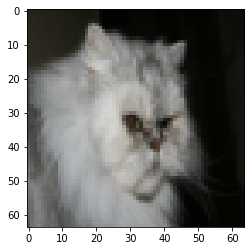

In [85]:
# 单独对图片进行预测

index = 10
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print(
    f'这张图的标签是 {test_set_y[0, index]}，预测结果是 {int(d["Y_prediction_test"][0, index])}')


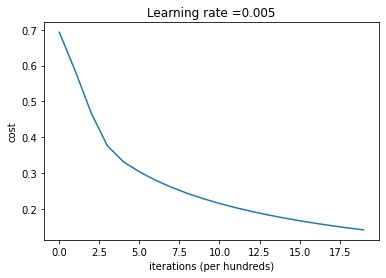

In [89]:
# 成本随训练次数的变化曲线
# 训练次数越多，成本越小，预测结果越精确

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')  # 成本
plt.xlabel('iterations (per hundreds)')  # 横坐标为训练次数，以100为单位
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()


学习率为: 0.01时
对训练图片的预测准确率为: 99.52153110047847%
对测试图片的预测准确率为: 68.0%

-------------------------------------------------------

学习率为: 0.001时
对训练图片的预测准确率为: 88.99521531100478%
对测试图片的预测准确率为: 64.0%

-------------------------------------------------------

学习率为: 0.0001时
对训练图片的预测准确率为: 68.42105263157895%
对测试图片的预测准确率为: 36.0%

-------------------------------------------------------



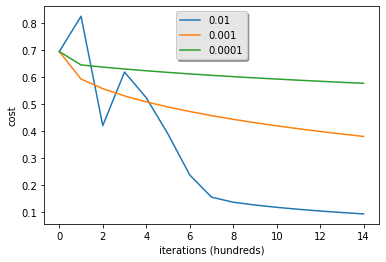

In [90]:
# 不同的学习率对训练过程的影响

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("学习率为: " + str(i) + "时")
    models[str(i)] = model(train_set_x, train_set_y, test_set_x,
                           test_set_y, num_iterations=1500, learning_rate=i, print_cost=False)
    print('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


预测结果为 1


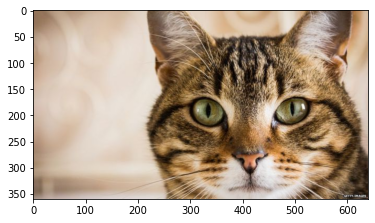

In [91]:
# 测试自己的图片

my_image = "cat.jpg"
fname = "images/" + my_image

image = np.array(plt.imread(fname))
my_image = tf.resize(image, (num_px, num_px),
                     mode='reflect').reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("预测结果为 " + str(int(np.squeeze(my_predicted_image))))
